In [23]:
# setup neural playground
import carabao
import carabao.screen
import carabao.cell

import importlib
importlib.reload(carabao)         # reload module
importlib.reload(carabao.screen)  # reload module
importlib.reload(carabao.cell)    # reload module

#=============================================================================
# class Rcell (rule based TM cell)
# usage: mon = Monitor(4,10)
#        cell = Rcell(mon,k,g,K,P)
#        cell.show()
#=============================================================================

class Cell:
    """
    Cell: class Cell - modelling cell algorithm

       from carabao.screen import Monitor
       from carabao.cell import Cell

       mon = Monitor(4,10)
       k,g,K,P = Toy('cell')

       cell = Cell(mon,k,g,K,P)
       cell.u = cell.y = cell.x = cell.b = 1
       cell.plot(i=0,j=0)    # plot at monitor location i,j
    """

    def __init__(self,mon,k,g,K,P):
        self.mon = mon

            # input, output, state variables

        self.u = 0             # basal (feedforwad) input
        self.y = 0             # cell output (axon)
        self.x = 0             # predictive state
        self.b = 0             # burst state
        self.P = P             # permanence matrix (state)

            # parameters and auxilliary variables

        self.config(k,g,K)
        self.x_ = 0            # auxilliary: x(t+1)
        self.P_ = self.P       # auxilliary: P(t+1)

    def config(self,k,g,K):
        self.eta = 0.5      # synaptic threshold
        self.theta = 2      # dendritic threshold
        self.pdelta = 0.04  # positive learning delata
        self.ndelta = 0.02  # negative learning delta
        self.k = k;
        self.g = g;
        self.K = K;

    def transition(self):              # state & permanence transition
        self.x = self.x_               # predictive state transition
        self.P = self.P_               # permanence state transition

    def update(self,c):                # update context with current output
        c[self.k] = self.y             # update context with changed output
        return c                       # return updated context

    def phase1(self,u,c):              # cell algo phase 1: update context
        self.transition()              # first perform state transition

            # rule 1: excited (u=1) & predictive (x=1) cells get active (y=1)

        self.u = u;                    # store input locally
        self.y = u * self.x            # excited & predictive cells get active
        #self.b = 0                    # clear burst state

            # update context c[k] with updated output y
            # note: c is only updated but not used for processing

            # record/log quantities (if verbose)

        self.mon.record(self,u,c)      # record current cell state
        return self.update(c)          # return updated context

    def phase2(self,u,c):              # cell algo phase 2: bursting
        self.u = u

           # rule 2: excited cells in a non-predictive group get bursting

        q = [c[k] for k in self.g]     # the group's outputs
        self.b = u * (sum(q) == 0)     # set cell's burst state

           # important: don't change output (and context vector) in this phase
           # before all cells in the context have determined their burst state

        self.mon.record(self,u,c,q)
        return self.update(c)          # return updated context

    def phase3(self,u,c):              # cell algo phase 3: process context
        self.u = u

            # rule 3: excited bursting cells get active

        self.y = self.y or (u * self.b)

            # rule 4: excided empowered dendritic segments are spiking

        V = self.select(c,self.K)          # pre-synaptic signals
        W = (self.P >= self.eta)           # synaptic (binary) weights
        Q = V * W                          # synapitcs matrix
        s = u * (norm(Q) >= self.theta)    # dentritic spike

            # rule 5: spiking dentrites of activated cells are learning
            # (calc permanences after transition)

        L = self.learn(Q)
        D = self.y * (L*Q*self.pdelta - L*self.ndelta)

        self.P_ = self.P + D           # learning (permanences after transition)

            # rule 6: active cells with spiking dendrites get predictive
            # (calc state after transition)

        self.x_ = s                # getting predictive

            # record this stuff

        self.mon.record(self,u,c,0,V,W,Q,L,D,s)
        return self.update(c)          # return updated context

    def phase(self,ph,u,c):             # cell algo phase i
        if ph == 1:
            return self.phase1(u,c)
        elif ph == 2:
            return self.phase2(u,c)
        elif ph == 3:
            return self.phase3(u,c)
        else:
            raise Exception("bad phase")

    def select(self,c,K):              # pre-synaptic signals
        V = 0*K
        for mu in range(0,K.shape[0]):
            for nu in range(0,K.shape[1]):
                V[mu,nu] = c[K[mu,nu]];
        return V

    def group(self,c,g):
        return [c[g[k]] for k in range(0,len(g))]

    def learn(self,Q):                  # learning vector
        d,s = Q.shape
        l = [];  p = []
        for mu in range(0,d):
            norm = sum(Q[mu]).item()
            l.append(norm)
            p.append(int(norm >= self.theta))
        L = trn(array([p])) @ ones((1,s))
        return L

    def plot(self,i=None,j=None,q=None,Q=None):
        self.mon.plot(self,i,j,q,Q)


v: [0, 0, 0, 1]
E: [[0 0 1 0 0]
 [0 1 0 0 0]]


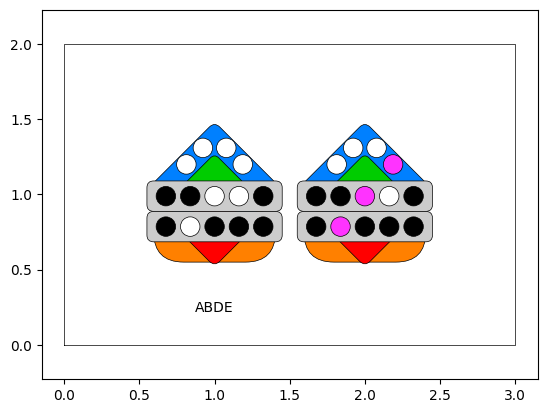

In [29]:
from carabao.screen import Monitor, hash
from carabao.cell import Cell, toy, select
from numpy import array,copy

mon = Monitor(1,2)
k,g,K,P,c = toy('cell')

cell = Cell(mon,k,g,K,P)
cell.u = cell.y = cell.x = cell.b = 1
cell.plot(i=0,j=0)   # plot at monitor location i,j

v = select(g,c)      # group  activation
print("v:",v)
W = (P>=0.5)         # binary weight matrix
E = W * select(K,c)  # empowerment (post synaptic effect matrix)
print("E:",E)
cell.plot(0,1,v,E)   # plot @ group activation v and empowerment E

(hash(None),hash(K),hash(P),hash(c),hash(v))
cell.mon.hash(cell)

from matplotlib.pyplot import plot
#mon.line([0,3],[0,0.5],'r',linewidth=2)
#mon.line([0,3],[0.5,0],'g',linewidth=2)
mon.text(1,0.25,mon.hash(cell)[0])